#RQ2: What patterns emerge across different price ranges and cateogires in Amazon Reviews

To explore this questions, I have copied the methodology used by Christian Levec for RQ3 to preprocess the data.


##Cells that need to be run once, everytime the notebook is loaded


In [2]:
!pip install datasets
!pip install vaderSentiment
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [5]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
import seaborn as sns
import gzip
import json
import re
import torch

drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/351_Data'
os.listdir(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['train.csv', 'test.csv', 'raw_data', 'meta', 'processed']

##Preprocessing steps (methodology was copied from Christian Levec for RQ3)


the only difference is that I included the helpful votes column

###Converting json data to csv. Filtered so only the necessary columns are downloaded

In [47]:
# Processes a JSONL.GZ file in chunks and writes only the needed fields to a CSV
# (Processing all at once would be much much slower)

def process_jsonl_in_chunks(filepath, output_path, fields_to_extract, chunk_size=10000, max_records=None):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    chunk = []
    chunk_counter = 0
    line_num = 0

    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"Existing output file found and deleted: {output_path}")

    print(f"Starting processing: {filepath}")

    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for line in f:
            line_num += 1
            if max_records is not None and line_num > max_records:
                print(f"Reached max_records limit of {max_records}. Stopping.")
                break
            try:
                json_obj = json.loads(line)
                filtered_obj = {field: json_obj.get(field, None) for field in fields_to_extract}
                chunk.append(filtered_obj)

                if len(chunk) >= chunk_size:
                    df_chunk = pd.DataFrame(chunk)
                    df_chunk.to_csv(
                        output_path,
                        mode='a',
                        index=False,
                        header=(chunk_counter == 0)
                    )
                    print(f"Saved chunk {chunk_counter} (lines up to {line_num})")
                    chunk = []
                    chunk_counter += 1
            except json.JSONDecodeError as e:
                print(f"JSON decoding error on line {line_num}: {e}")

    if chunk:
        df_chunk = pd.DataFrame(chunk)
        df_chunk.to_csv(
            output_path,
            mode='a',
            index=False,
            header=(chunk_counter == 0)
        )
        print(f"Saved final chunk {chunk_counter} (lines up to {line_num})")

    print(f"Finished processing! Output saved to: {output_path}")

#Chosen columns for meta data
data_fields = [
    'parent_asin',
    'title',
    'text',
    'rating',
    'verified_purchase',
    'timestamp',
    'helpful_votes'
]

#Paths for each meta file
raw_review_paths = {
    "Pet_Supplies": "/content/drive/My Drive/351_Data/raw_data/Pet_Supplies.jsonl.gz",
    "Electronics": "/content/drive/My Drive/351_Data/raw_data/Electronics.jsonl.gz",
    "All_Beauty": "/content/drive/My Drive/351_Data/raw_data/All_Beauty.jsonl.gz",
    "Home_and_Kitchen": "/content/drive/My Drive/351_Data/raw_data/Home_and_Kitchen.jsonl.gz",
    "Grocery_and_Gourmet_Food": "/content/drive/My Drive/351_Data/raw_data/Grocery_and_Gourmet_Food.jsonl.gz"
}

# Output paths (updated to avoid overwriting Christian's originals)
output_review_paths = {
    "Pet_Supplies": "/content/drive/My Drive/351_Data/processed/Pet_Supplies_with_helpful.csv",
    "Electronics": "/content/drive/My Drive/351_Data/processed/Electronics_with_helpful.csv",
    "All_Beauty": "/content/drive/My Drive/351_Data/processed/All_Beauty_with_helpful.csv",
    "Home_and_Kitchen": "/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_with_helpful.csv",
    "Grocery_and_Gourmet_Food": "/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_with_helpful.csv"
}

#loop through each category and process
for category in raw_review_paths:
    print(f"\n=== Processing {category} ===")
    process_jsonl_in_chunks(
        filepath=raw_review_paths[category],
        output_path=output_review_paths[category],
        fields_to_extract=data_fields,
        chunk_size=10000,
        max_records=100000  #get 100k records
    )



=== Processing Pet_Supplies ===
Existing output file found and deleted: /content/drive/My Drive/351_Data/processed/Pet_Supplies_with_helpful.csv
Starting processing: /content/drive/My Drive/351_Data/raw_data/Pet_Supplies.jsonl.gz
Saved chunk 0 (lines up to 10000)
Saved chunk 1 (lines up to 20000)
Saved chunk 2 (lines up to 30000)
Saved chunk 3 (lines up to 40000)
Saved chunk 4 (lines up to 50000)
Saved chunk 5 (lines up to 60000)
Saved chunk 6 (lines up to 70000)
Saved chunk 7 (lines up to 80000)
Saved chunk 8 (lines up to 90000)
Saved chunk 9 (lines up to 100000)
Reached max_records limit of 100000. Stopping.
Finished processing! Output saved to: /content/drive/My Drive/351_Data/processed/Pet_Supplies_with_helpful.csv

=== Processing Electronics ===
Existing output file found and deleted: /content/drive/My Drive/351_Data/processed/Electronics_with_helpful.csv
Starting processing: /content/drive/My Drive/351_Data/raw_data/Electronics.jsonl.gz
Saved chunk 0 (lines up to 10000)
Saved ch

###Merging metadata and review date files together for easier model training


In [48]:
#Load and merge pet supplies
df_pet_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv')
df_pet_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_with_helpful.csv')

df_pet_merged = df_pet_reviews.merge(
    df_pet_meta[['parent_asin', 'price', 'main_category', 'average_rating', 'rating_number']],
    on='parent_asin',
    how='left'
)
df_pet_merged = df_pet_merged[df_pet_merged['verified_purchase'] == True]
print("Pet Supplies merged")
print(df_pet_merged.head())

#Load and merge electronics
df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')
df_elec_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Electronics_with_helpful.csv')

df_elec_merged = df_elec_reviews.merge(
    df_elec_meta[['parent_asin', 'price', 'main_category','average_rating', 'rating_number']],
    on='parent_asin',
    how='left'
)
df_elec_merged = df_elec_merged[df_elec_merged['verified_purchase'] == True]
print("Electronics merged")
print(df_elec_merged.head())

#Load and merge all beauty
df_beauty_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_All_Beauty_processed.csv')
df_beauty_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_with_helpful.csv')

df_beauty_merged = df_beauty_reviews.merge(
    df_beauty_meta[['parent_asin', 'price', 'main_category','average_rating', 'rating_number']],
    on='parent_asin',
    how='left'
)
df_beauty_merged = df_beauty_merged[df_beauty_merged['verified_purchase'] == True]
print("All Beauty merged")
print(df_beauty_merged.head())

#Load and merge home and kitchen
df_home_kitchen_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Home_and_Kitchen_processed.csv')
df_home_kitchen_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_with_helpful.csv')

df_home_kitchen_merged = df_home_kitchen_reviews.merge(
    df_home_kitchen_meta[['parent_asin', 'price', 'main_category','average_rating', 'rating_number']],
    on='parent_asin',
    how='left'
)
df_home_kitchen_merged = df_home_kitchen_merged[df_home_kitchen_merged['verified_purchase'] == True]
print("Home and Kitchen merged")
print(df_home_kitchen_merged.head())

#Load and merge grocery and gourmet Food
df_grocery_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Grocery_and_Gourmet_Food_processed.csv')
df_grocery_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_with_helpful.csv')

df_grocery_merged = df_grocery_reviews.merge(
    df_grocery_meta[['parent_asin', 'price', 'main_category','average_rating', 'rating_number']],
    on='parent_asin',
    how='left'
)
df_grocery_merged = df_grocery_merged[df_grocery_merged['verified_purchase'] == True]
print("Grocery and Gourmet Food merged")
print(df_grocery_merged.head())


Pet Supplies merged
  parent_asin                                              title  \
0  B0BHTBS5RM  Sticky stair riser tread thingies are utterly ...   
1  B0BJ16KKML  Dangerous bc metal not properly coated! Rough ...   
2  B0BX76YVP9                      Arrived damaged/dented/rusted   
3  B0BM6V2SH8                                My pups love these!   
4  B0986BSRB1                        My pups refuse to eat them.   

                                                text  rating  \
0  Tried to load photos, but none of my photos or...     4.0   
1  Where to begin?  I’ve been trying to get the 2...     1.0   
2  Unfortunately mine arrived damaged/dented whic...     3.0   
3  My pups love these!  It’s one of their favorit...     5.0   
4  Idk why, but my pups will not eat either flavo...     3.0   

   verified_purchase      timestamp  helpful_votes  price main_category  \
0               True  1675529329744            NaN  53.62  Pet Supplies   
1               True  1665513673369 

<ipython-input-48-85fcffc0a153>:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')


Electronics merged
  parent_asin                                        title  \
0  B083NRGZMM            Smells like gasoline! Going back!   
1  B07N69T6TM      Didn’t work at all lenses loose/broken.   
2  B01G8JO5F2                                   Excellent!   
3  B001OC5JKY                       Great laptop backpack!   
4  B07CJYMRWM  Best Headphones in the Fifties price range!   

                                                text  rating  \
0  First & most offensive: they reek of gasoline ...     3.0   
1  These didn’t work. Idk if they were damaged in...     1.0   
2  I love these. They even come with a carry case...     5.0   
3  I was searching for a sturdy backpack for scho...     5.0   
4  I've bought these headphones three times becau...     5.0   

   verified_purchase      timestamp  helpful_votes price main_category  \
0               True  1658185117948            NaN   NaN           NaN   
1               True  1592678549731            NaN   NaN           NaN   
2

##Elementary statistical analysis + subsequent data processing/cleaning


In [13]:
df_pet_merged['category'] = 'Pet Supplies'
df_elec_merged['category'] = 'Electronics'
df_beauty_merged['category'] = 'All Beauty'
df_home_kitchen_merged['category'] = 'Home and Kitchen'
df_grocery_merged['category'] = 'Grocery and Gourmet Food'

df_all = pd.concat([
    df_pet_merged,
    df_elec_merged,
    df_beauty_merged,
    df_home_kitchen_merged,
    df_grocery_merged
], ignore_index=True)
print("Shape of combined dataset:", df_all.shape)
print("\nColumn names:")
print(df_all.columns)

print("\nSample rows:")
print(df_all.head())

print("\nMissing values per column:")
print(df_all.isnull().sum())



Shape of combined dataset: (397022, 12)

Column names:
Index(['parent_asin', 'title', 'text', 'rating', 'verified_purchase',
       'timestamp', 'helpful_votes', 'price', 'main_category',
       'average_rating', 'rating_number', 'category'],
      dtype='object')

Sample rows:
  parent_asin                                              title  \
0  B0BHTBS5RM  Sticky stair riser tread thingies are utterly ...   
1  B0BJ16KKML  Dangerous bc metal not properly coated! Rough ...   
2  B0BX76YVP9                      Arrived damaged/dented/rusted   
3  B0BM6V2SH8                                My pups love these!   
4  B0986BSRB1                        My pups refuse to eat them.   

                                                text  rating  \
0  Tried to load photos, but none of my photos or...     4.0   
1  Where to begin?  I’ve been trying to get the 2...     1.0   
2  Unfortunately mine arrived damaged/dented whic...     3.0   
3  My pups love these!  It’s one of their favorit...    

In [16]:
#replace helpful_votes NaN with 0
df_all['helpful_votes'] = df_all['helpful_votes'].fillna(0)

#drop rows without a price
df_all = df_all.dropna(subset=['price'])

#ensure price is float
df_all['price'] = pd.to_numeric(df_all['price'], errors='coerce')

#drop rows with price conversion issues
df_all = df_all.dropna(subset=['price'])

#fill missing review text with empty string
df_all['text'] = df_all['text'].fillna("")

#compute review length
df_all['review_length'] = df_all['text'].apply(len)

#show shape after cleaning
print("Cleaned dataset shape:", df_all.shape)

category_summary = df_all.groupby('category').agg({
    'price': ['mean', 'median', 'std'],
    'rating': ['mean', 'std'],
    'helpful_votes': ['mean', 'std'],
    'review_length': 'mean'
}).round(2)

#flatten columns
category_summary.columns = ['_'.join(col).strip() for col in category_summary.columns.values]

print(category_summary)


Cleaned dataset shape: (99388, 13)
                          price_mean  price_median  price_std  rating_mean  \
category                                                                     
All Beauty                     21.07         14.99      24.80         4.21   
Electronics                    53.63         19.99     144.35         4.32   
Grocery and Gourmet Food       21.44         17.49      18.35         4.33   
Home and Kitchen               42.46         24.99      72.36         4.38   
Pet Supplies                   31.00         22.77      28.43         4.22   

                          rating_std  helpful_votes_mean  helpful_votes_std  \
category                                                                      
All Beauty                      1.31                 0.0                0.0   
Electronics                     1.23                 0.0                0.0   
Grocery and Gourmet Food        1.22                 0.0                0.0   
Home and Kitchen       

##Data analysis

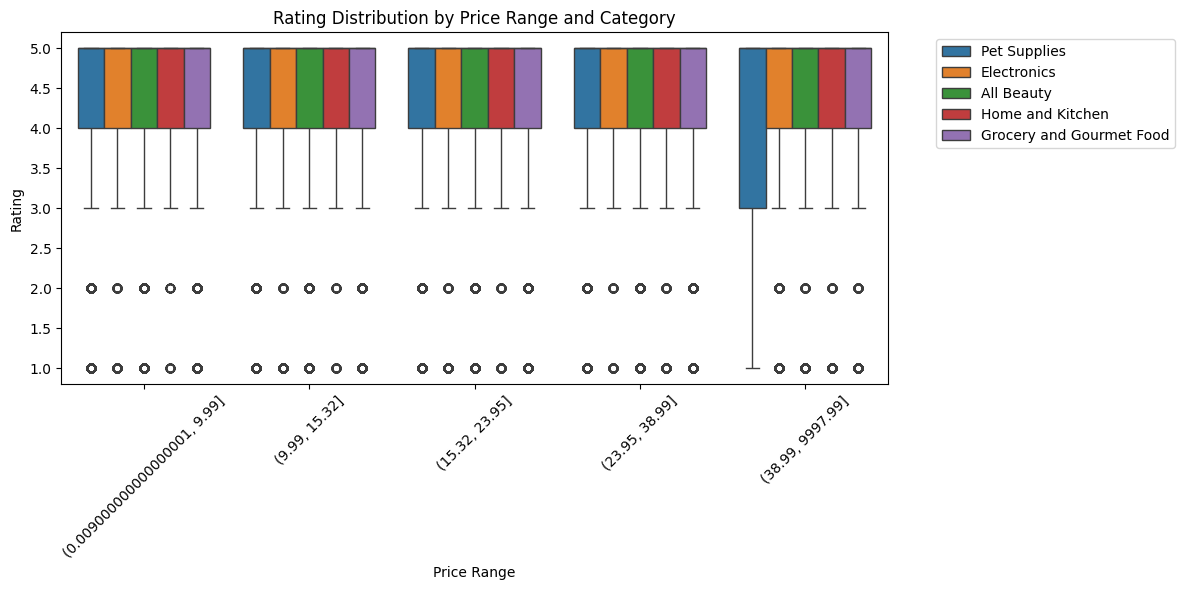

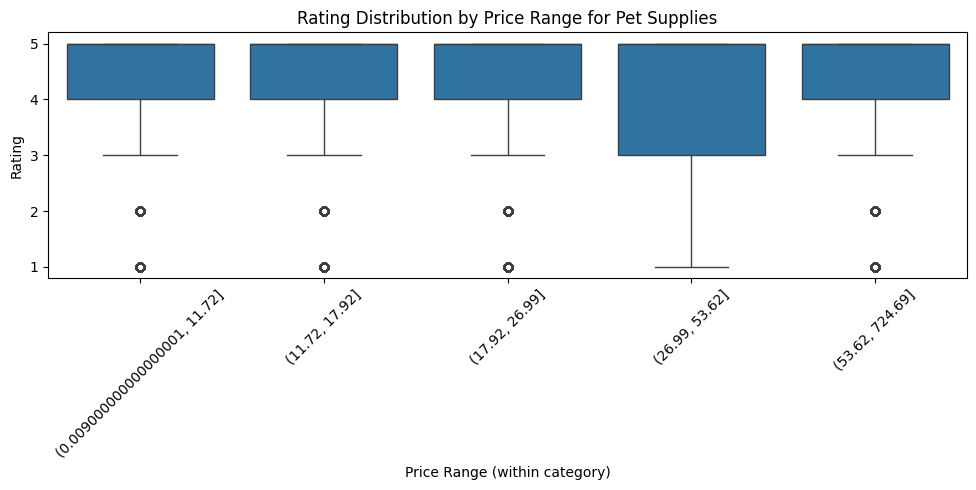

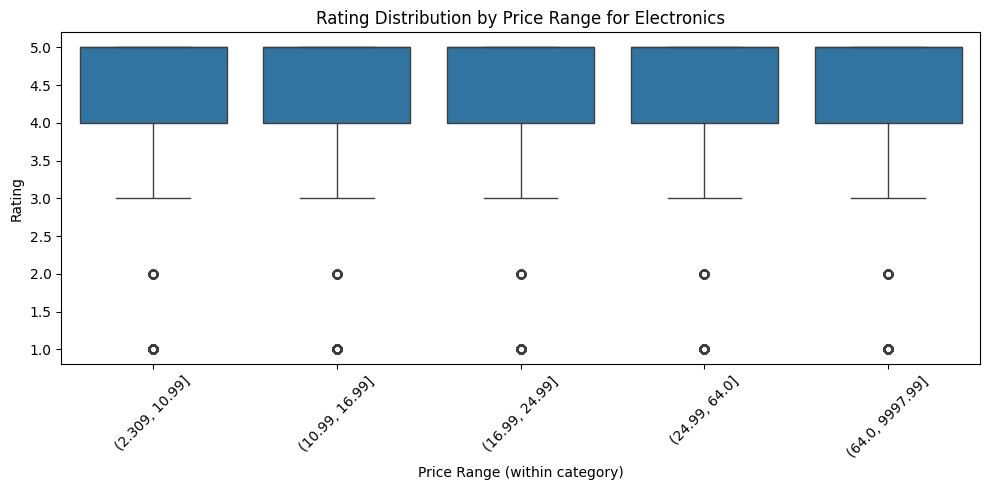

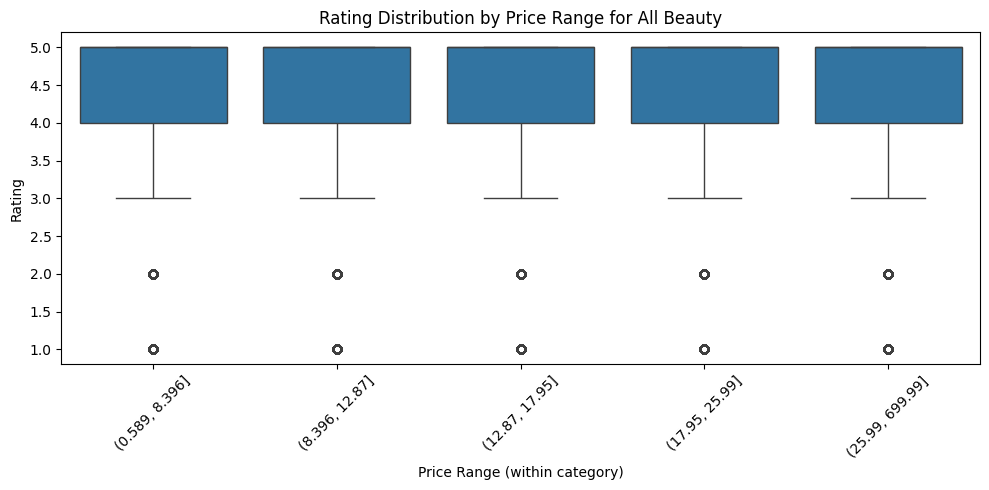

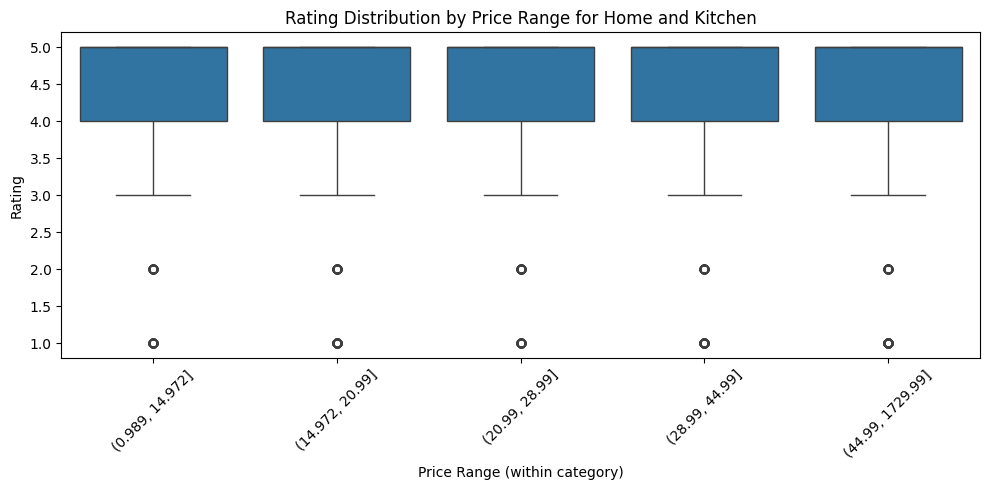

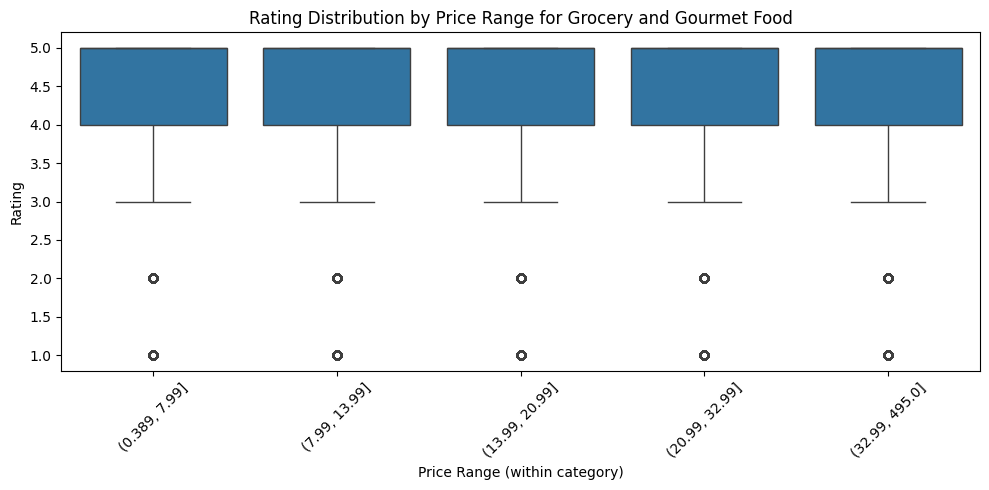

        price  rating       price_bin
318410  35.52     5.0  (32.99, 495.0]
318414  17.87     5.0  (13.99, 20.99]
318416   8.34     5.0   (7.99, 13.99]
318420   8.68     5.0   (7.99, 13.99]
318421  20.80     5.0  (13.99, 20.99]
318425  34.39     5.0  (32.99, 495.0]
318427  22.53     1.0  (20.99, 32.99]
318428  27.54     1.0  (20.99, 32.99]
318429  30.99     5.0  (20.99, 32.99]
318431  15.24     5.0  (13.99, 20.99]


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bin prices into 5 bins based on %
df_all['price_bin'] = pd.qcut(df_all['price'], q=5, duplicates='drop')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all, x='price_bin', y='rating', hue='category')
plt.title('Rating Distribution by Price Range and Category')
plt.xticks(rotation=45)
plt.ylabel('Rating')
plt.xlabel('Price Range')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

categories = df_all['category'].unique()

for cat in categories:
    # Subset the category
    df_cat = df_all[df_all['category'] == cat].copy()

    #Create price bins just for this category
    df_cat['price_bin'] = pd.qcut(df_cat['price'], q=5, duplicates='drop')

    #Plot rating distribution by price bin
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_cat, x='price_bin', y='rating')
    plt.title(f'Rating Distribution by Price Range for {cat}')
    plt.xticks(rotation=45)
    plt.ylabel('Rating')
    plt.xlabel('Price Range (within category)')
    plt.tight_layout()
    plt.show()


print(df_cat[['price', 'rating', 'price_bin']].head(10))


In [49]:
#Get raw counts as before
rating_counts = df_all.groupby(['category', 'rating']).size().unstack(fill_value=0)

#Convert to percentages
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages = rating_percentages.round(2)
print("Rating distribution by category (in %):")
print(rating_percentages)


Rating distribution by category (in %):
rating                     1.0   2.0   3.0    4.0    5.0
category                                                
All Beauty                9.03  5.07  8.24  11.53  66.12
Electronics               7.79  3.81  7.02  11.87  69.51
Grocery and Gourmet Food  7.23  4.28  6.91  11.03  70.54
Home and Kitchen          6.16  3.97  6.83  11.75  71.29
Pet Supplies              8.46  5.33  8.47  11.58  66.16


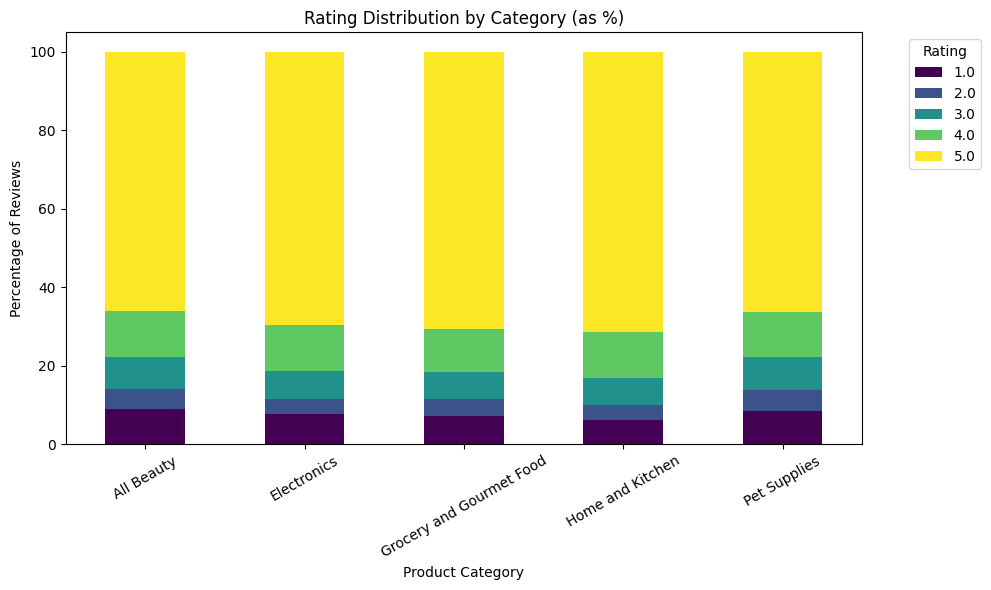

In [50]:
import matplotlib.pyplot as plt

# Reuse the rating_percentages DataFrame from earlier
rating_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='viridis'
)

plt.title("Rating Distribution by Category (as %)")
plt.ylabel("Percentage of Reviews")
plt.xlabel("Product Category")
plt.xticks(rotation=30)
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [26]:
# Calculate % of 1-star and 5-star reviews
rating_counts = df_all.groupby(['category', 'rating']).size().unstack(fill_value=0)
rating_percents = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# create summary stats per category
cluster_df = df_all.groupby('category').agg({
    'price': ['mean', 'std'],
    'rating': ['mean', 'std'],
    'review_length': 'mean'
})

# flatten multi-level columns
cluster_df.columns = ['_'.join(col) for col in cluster_df.columns]
cluster_df.reset_index(inplace=True)

# Merge in % of 1-star and 5-star reviews
cluster_df['pct_1_star'] = rating_percents[1.0].values
cluster_df['pct_5_star'] = rating_percents[5.0].values


print(cluster_df)


                   category  price_mean   price_std  rating_mean  rating_std  \
0                All Beauty   21.067377   24.797673     4.206381    1.310342   
1               Electronics   53.631927  144.349067     4.315144    1.232663   
2  Grocery and Gourmet Food   21.439324   18.354675     4.333773    1.218681   
3          Home and Kitchen   42.459135   72.364044     4.380525    1.161803   
4              Pet Supplies   31.001400   28.430959     4.216609    1.293720   

   review_length_mean  pct_1_star  pct_5_star  
0          161.832508    9.032232   66.124056  
1          233.440886    7.789640   69.513642  
2          174.858475    7.230033   70.542863  
3          203.167317    6.162246   71.294852  
4          205.915007    8.458121   66.159289  


##K means Cluster Analysis


In [30]:
from sklearn.preprocessing import StandardScaler

features_to_cluster = ['price_mean', 'price_std', 'rating_mean', 'rating_std',
                      'pct_1_star', 'pct_5_star']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[features_to_cluster])


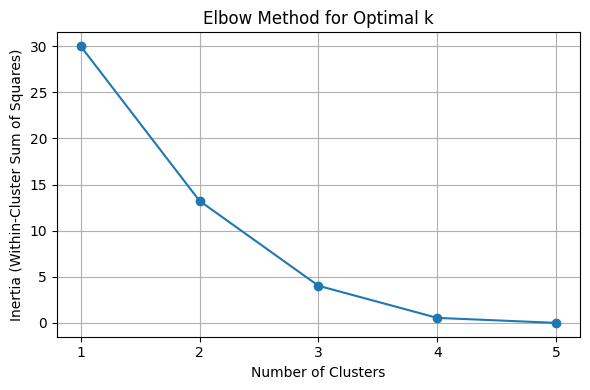

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

# Try k from 1 to 5
for k in range(1, 6):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(6,4))
plt.plot(range(1, 6), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()


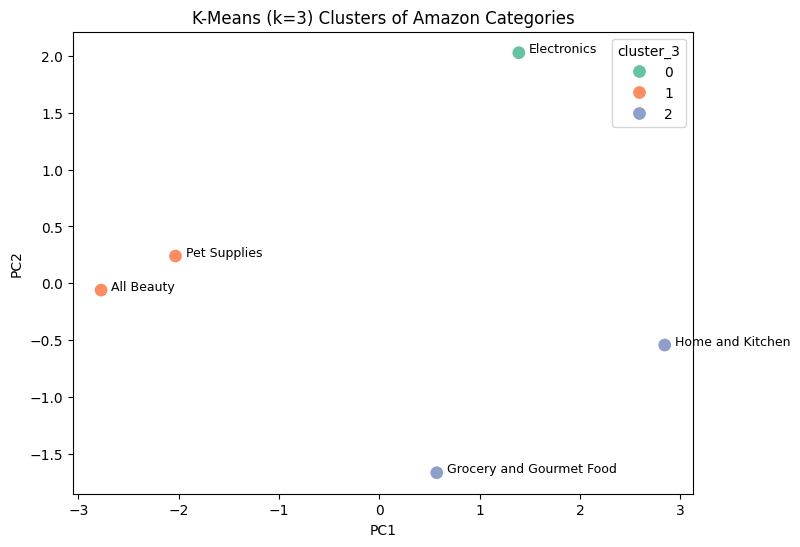

In [39]:
# Rrun KMeans with 3 clusters
kmeans3 = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster_3'] = kmeans3.fit_predict(X_scaled)

# Run PCA projection
X_pca = PCA(n_components=2).fit_transform(X_scaled)
cluster_df['PC1'] = X_pca[:, 0]
cluster_df['PC2'] = X_pca[:, 1]

# Plot with 3 clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='cluster_3', palette='Set2', s=100)
for i in range(cluster_df.shape[0]):
    plt.text(x=cluster_df['PC1'][i]+0.1, y=cluster_df['PC2'][i], s=cluster_df['category'][i], fontsize=9)
plt.title("K-Means (k=3) Clusters of Amazon Categories")
plt.show()


In [41]:
cluster_features = cluster_df[['cluster_3', 'price_mean', 'price_std',
                               'rating_mean', 'rating_std',
                               'pct_1_star', 'pct_5_star']]

# Group by cluster and compute mean per feature
cluster_summary = cluster_features.groupby('cluster_3').mean().round(2)
print(cluster_summary)


           price_mean  price_std  rating_mean  rating_std  pct_1_star  \
cluster_3                                                               
0               53.63     144.35         4.32        1.23        7.79   
1               26.03      26.61         4.21        1.30        8.75   
2               31.95      45.36         4.36        1.19        6.70   

           pct_5_star  
cluster_3              
0               69.51  
1               66.14  
2               70.92  


In [51]:
correlations = df_all.groupby('category').apply(lambda x: x[['price', 'rating']].corr().iloc[0, 1])
print("Correlation between Price and Rating by Category:\n", correlations)


Correlation between Price and Rating by Category:
 category
All Beauty                  0.028357
Electronics                -0.007060
Grocery and Gourmet Food    0.010624
Home and Kitchen           -0.019222
Pet Supplies               -0.038650
dtype: float64


<ipython-input-51-f4e6b8684ff5>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_all.groupby('category').apply(lambda x: x[['price', 'rating']].corr().iloc[0, 1])


comparing least vs most expensive products in each category

In [54]:
for cat in df_all['category'].unique():
    cat_df = df_all[df_all['category'] == cat]
    top = cat_df.sort_values(by='price', ascending=False).head(5)
    bottom = cat_df.sort_values(by='price', ascending=True).head(5)
    print(f"\n{cat} - Most Expensive Products:\n", top[['title', 'price', 'rating']])
    print(f"\n{cat} - Least Expensive Products:\n", bottom[['title', 'price', 'rating']])



Pet Supplies - Most Expensive Products:
                                                    title   price  rating
17875                  Inconsistent sizes. Too expensive  724.69     2.0
26502  My dogs are super fast chewers and these took ...  724.69     5.0
51408             Winston the golden puppy LOVES these!!  724.69     5.0
62823                                     Grooming table  649.99     5.0
6880                                 Holds up to my Labs  649.99     5.0

Pet Supplies - Least Expensive Products:
                                               title  price  rating
40210                                            Ok   0.01     5.0
77359                                      Adorable   0.01     5.0
27724                                 Happy cosumer   0.29     5.0
76                             It's very nice dress   0.85     5.0
3873   Great return & replacement from the Seller!!   1.01     5.0

Electronics - Most Expensive Products:
                                   

top rated vs lowest rated products by price tier


In [55]:
df_all['rating_label'] = df_all['rating'].apply(lambda x: 'Low' if x <= 2 else 'High' if x >= 4 else 'Mid')
rating_price_crosstab = pd.crosstab(df_all['rating_label'], df_all['price_bin'])

print(rating_price_crosstab)


price_bin     (0.009000000000000001, 9.99]  (9.99, 15.32]  (15.32, 23.95]  \
rating_label                                                                
High                                 16753          14831           15979   
Low                                   2800           2268            2454   
Mid                                   1706           1410            1534   

price_bin     (23.95, 38.99]  (38.99, 9997.99]  
rating_label                                    
High                   15969             15275  
Low                     2376              2913  
Mid                     1451              1669  
